Evaluating random masking for PRSA - LSTM...


Evaluating masking percentages: 100%|██████████| 101/101 [00:00<00:00, 209.15it/s]


Evaluating random masking for PRSA - TCN...


Evaluating masking percentages: 100%|██████████| 101/101 [00:00<00:00, 156.87it/s]


Evaluating random masking for PRSA - Transformer...


Evaluating masking percentages: 100%|██████████| 101/101 [00:01<00:00, 68.78it/s]


Evaluating random masking for SZtick - LSTM...


Evaluating masking percentages: 100%|██████████| 101/101 [00:00<00:00, 266.74it/s]


Evaluating random masking for SZtick - TCN...


Evaluating masking percentages: 100%|██████████| 101/101 [00:00<00:00, 200.00it/s]


Evaluating random masking for SZtick - Transformer...


Evaluating masking percentages: 100%|██████████| 101/101 [00:01<00:00, 80.08it/s]


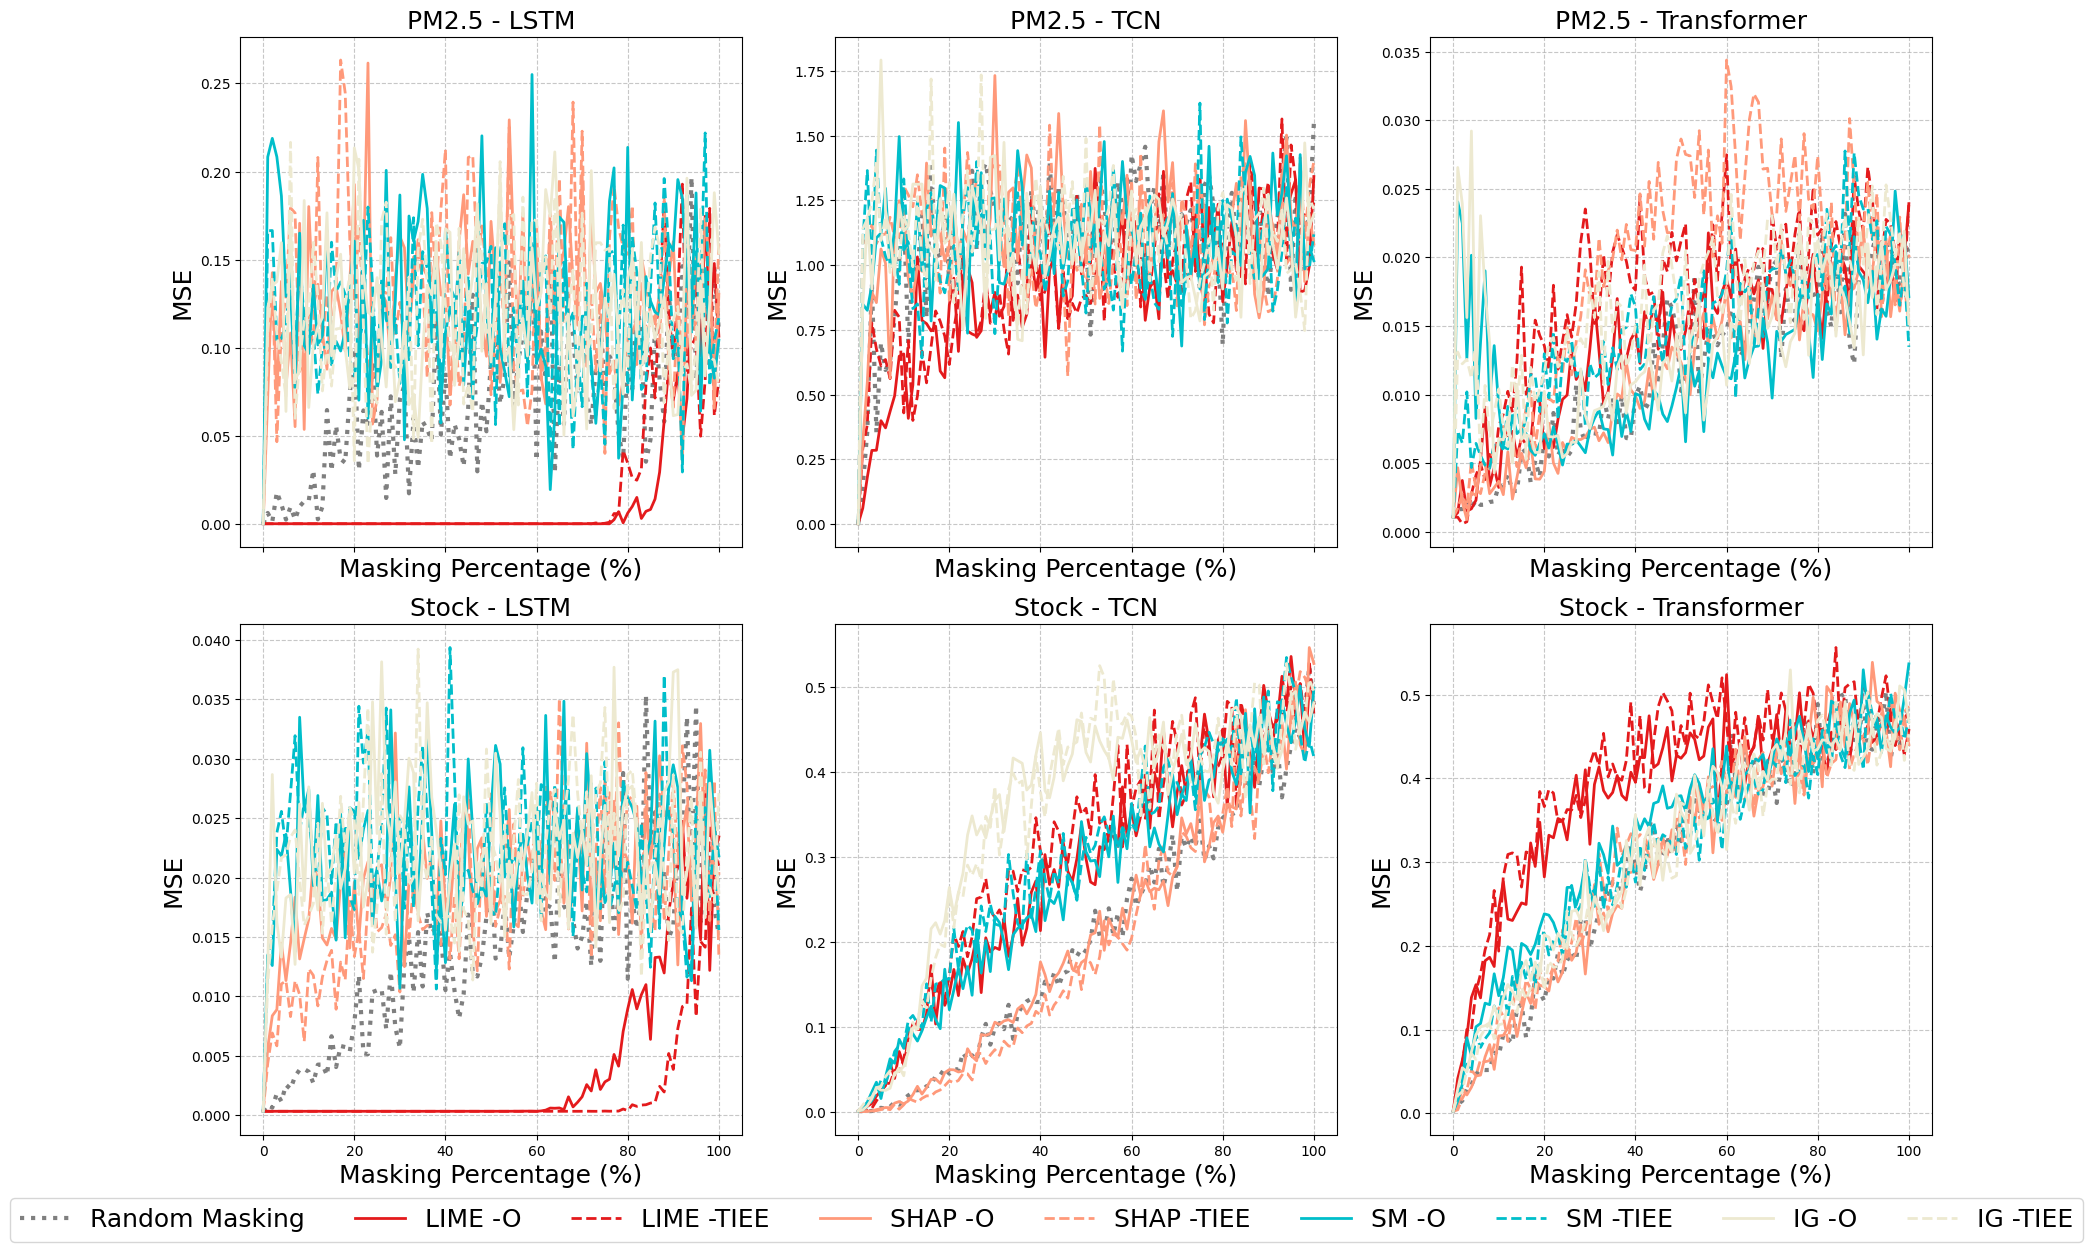

In [29]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import dill
import os
from copy import deepcopy
import random
import matplotlib.lines as mlines

# 设置随机种子以确保可重复性
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 配置参数
home = "/storage/d05/cys/CYS/robust-timepoint/"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
n_samples = 25

# 创建大图
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=False)
# fig.suptitle("Faithfulness Evaluation Across Datasets and Models", fontsize=20)

# 定义数据集和模型
datasets = ["PRSA", "SZtick"]  # PM2.5数据集和股票数据集
display_names = {"PRSA": "PM2.5", "SZtick": "Stock"}  # 显示名称映射
models = ["LSTM", "TCN", "Transformer"]  # 三种模型
xai_methods = ['LIME', 'KS', 'SM', 'IG']
display_methods = ['LIME', 'SHAP', 'SM', 'IG']
# colors = ['#6e73e2', '#b3ade4', '#f1edff', '#6cbaa2']  # 四种颜色对应四种方法
colors = ['#e41a1c', '#ff997a', '#00beca', '#ede9d0']  # 四种颜色对应四种方法
line_styles = {'original': '-', 'TIEE': '--'}

# 设置评估参数
masked_percentages = list(range(0, 101, 1))  # 步长1%

# 定义评估函数
def evaluate_masked_performance(X, y, saliency, model, masked_percentages, random_mask=False):
    """
    评估不同遮盖比例下的模型性能
    random_mask: 是否使用随机遮盖（忽略saliency）
    """
    mse_scores = []
    n_samples, n_timesteps, n_features = X.shape
    
    # 将时间序列展平为特征向量 (样本数, 时间步长*特征数)
    X_flat = X.reshape(n_samples, -1)
    
    # 如果使用随机遮盖，生成随机重要性排序
    if random_mask:
        saliency_flat = np.random.rand(n_samples, n_timesteps * n_features)
    else:
        saliency_flat = saliency.reshape(n_samples, -1)
    
    # 对每个遮盖比例进行评估
    for pct in tqdm(masked_percentages, desc="Evaluating masking percentages"):
        X_masked = deepcopy(X_flat)
        
        # 对每个样本独立处理
        for i in range(n_samples):
            # 获取当前样本的重要性排序
            sample_saliency = saliency_flat[i]
            sorted_indices = np.argsort(sample_saliency)[::-1] 
            
            # 计算需要遮盖的特征数量
            n_features_total = n_timesteps * n_features
            n_mask = int(n_features_total * pct / 100)
            
            # 遮盖最重要的特征
            mask_indices = sorted_indices[:n_mask]

            # 使用随机噪声遮盖
            noise = np.random.normal(0, 1, size=n_mask)  # 生成随机噪声
            X_masked[i, mask_indices] = noise
        
        # 恢复原始形状并转换为tensor
        X_masked = X_masked.reshape(n_samples, n_timesteps, n_features)
        X_tensor = torch.tensor(X_masked).to(device)
        y_tensor = torch.tensor(y).to(device)
        
        # 模型预测并计算MSE
        with torch.no_grad():
            preds = model(X_tensor)
            mse = nn.MSELoss()(preds.squeeze(), y_tensor).item()
        
        mse_scores.append(mse)

    return mse_scores

# 创建自定义图例元素
legend_elements = [
    # 随机遮盖
    mlines.Line2D([], [], color='#7f7f7f', linestyle=':', linewidth=3, label='Random Masking'),
]

# 添加解释方法图例
for i, method in enumerate(display_methods):
    legend_elements.append(
        mlines.Line2D([], [], color=colors[i], linestyle='-', linewidth=2, label=f'{method} -O')
    )
    legend_elements.append(
        mlines.Line2D([], [], color=colors[i], linestyle='--', linewidth=2, label=f'{method} -TIEE')
    )

# 遍历所有数据集和模型
for row_idx, data_name in enumerate(datasets):
    # 加载数据集
    with open(os.path.join(home, "Datasets", f"{data_name}120.dill"), 'rb') as f:
        dataset = dill.load(f)
    X_test = dataset[2][:n_samples]  
    y_test = dataset[3][:n_samples]
    
    for col_idx, model_name in enumerate(models):
        # 获取当前子图
        ax = axes[row_idx, col_idx]
        
        # 加载模型
        model_path = os.path.join(home, "Models", f"{model_name}/{data_name}_120_BEST.pkl")
        model = torch.load(model_path, map_location=device)
        model.eval()
        
        # 添加随机遮盖的基准线
        print(f"Evaluating random masking for {data_name} - {model_name}...")
        random_scores = evaluate_masked_performance(X_test, y_test, None, model, masked_percentages, random_mask=True)
        ax.plot(masked_percentages, random_scores, 
                 color='#7f7f7f',  # 灰色
                 linestyle=':',  # 点线
                 linewidth=3)

        # 对每种解释方法进行评估
        for i, method in enumerate(xai_methods):
            # 原始解释方法
            saliency_path = os.path.join(home, "Results", "Saliency_Values", 
                                        data_name, model_name, f"{method}.npy")
            orig_saliency = np.load(saliency_path)[:n_samples]  # 仅取前25个样本
            
            orig_scores = evaluate_masked_performance(X_test, y_test, orig_saliency, 
                                                    model, masked_percentages)
            
            # 增强解释方法
            enhanced_saliency_path = os.path.join(home, "Results", "Smooth_Saliency", 
                                                 data_name, model_name, f"{method}.npy")
            enhanced_saliency = np.load(enhanced_saliency_path)[:n_samples]  # 仅取前25个样本
            
            enhanced_scores = evaluate_masked_performance(X_test, y_test, enhanced_saliency, 
                                                         model, masked_percentages)
            
            # 绘制原始方法曲线
            ax.plot(masked_percentages, orig_scores, 
                     color=colors[i], 
                     linestyle=line_styles['original'],
                     linewidth=2)
            
            # 绘制增强方法曲线
            ax.plot(masked_percentages, enhanced_scores, 
                     color=colors[i], 
                     linestyle=line_styles['TIEE'],
                     linewidth=2)
        
        # 设置子图标题和标签 - 使用显示名称
        display_data_name = display_names.get(data_name, data_name)  # 获取显示名称
        ax.set_title(f"{display_data_name} - {model_name}", fontsize=18)
        ax.set_xlabel("Masking Percentage (%)", fontsize=18)
        ax.set_ylabel("MSE", fontsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # 设置统一的纵轴范围
        # ax.set_ylim(0, 1.0)

# 添加整体图例（在底部水平排列）
fig.legend(handles=legend_elements, 
           loc='lower center', 
           ncol=len(legend_elements),  # 分成两行
           fontsize=18,
           bbox_to_anchor=(0.5, -0.05))

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)  # 为底部图例留出空间

# 保存图像
output_path = os.path.join(home, "Results", "Plots", "combined_faithfulness_evaluation.png")
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

Evaluating masking percentages: 100%|██████████| 101/101 [00:01<00:00, 79.34it/s]


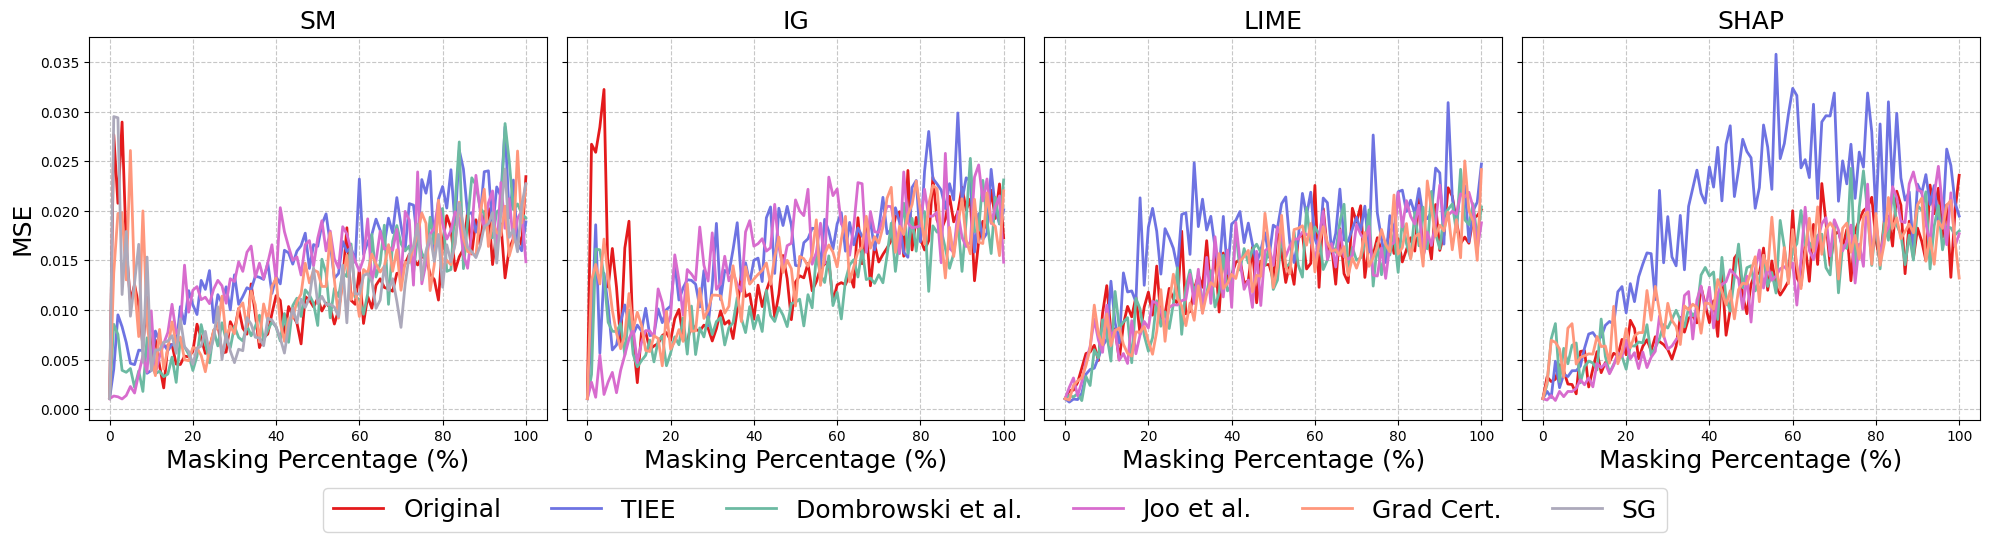

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import dill
import os
from copy import deepcopy
import random
import matplotlib.lines as mlines

# 设置随机种子以确保可重复性
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 配置参数
home = "/storage/d05/cys/CYS/robust-timepoint/"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
n_samples = 25
data_name = "PRSA"  # 使用PM2.5数据集
model_name = "Transformer"  # 使用Transformer模型

# 创建大图
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

# 定义解释方法和增强版本
methods = {
    'SM': {'display': 'SM', 'file': 'SM'},
    'IG': {'display': 'IG', 'file': 'IG'},
    'LIME': {'display': 'LIME', 'file': 'LIME'},
    'SHAP': {'display': 'SHAP', 'file': 'KS'}  # 文件名是KS，显示为SHAP
}
enhancements = ['Original', 'TIEE', 'Dombrowski et al.', 'Joo et al.', 'Grad Cert.']

# 使用高对比度颜色方案
colors = [
    '#e41a1c',  # 红色 - Original
    '#6e73e2',  # 蓝色 - TIEE
    '#6cbaa2',  # 绿色 - 11
    '#d86cce',  # 紫色 - 31
    '#ff977c'   # 橙色 - 32
]
sg_color = '#aca9bb'  # 棕色 - SG方法

# 设置评估参数
masked_percentages = list(range(0, 101, 1))  # 步长1%

# 定义评估函数
def evaluate_masked_performance(X, y, saliency, model, masked_percentages):
    """
    评估不同遮盖比例下的模型性能
    """
    mse_scores = []
    n_samples, n_timesteps, n_features = X.shape
    
    # 将时间序列展平为特征向量 (样本数, 时间步长*特征数)
    X_flat = X.reshape(n_samples, -1)
    saliency_flat = saliency.reshape(n_samples, -1)
    
    # 对每个遮盖比例进行评估
    for pct in tqdm(masked_percentages, desc="Evaluating masking percentages"):
        X_masked = deepcopy(X_flat)
        
        # 对每个样本独立处理
        for i in range(n_samples):
            # 获取当前样本的重要性排序
            sample_saliency = saliency_flat[i]
            sorted_indices = np.argsort(sample_saliency)[::-1] 
            
            # 计算需要遮盖的特征数量
            n_features_total = n_timesteps * n_features
            n_mask = int(n_features_total * pct / 100)
            
            # 遮盖最重要的特征
            mask_indices = sorted_indices[:n_mask]

            # 使用随机噪声遮盖
            noise = np.random.normal(0, 1, size=n_mask)  # 生成随机噪声
            X_masked[i, mask_indices] = noise
        
        # 恢复原始形状并转换为tensor
        X_masked = X_masked.reshape(n_samples, n_timesteps, n_features)
        X_tensor = torch.tensor(X_masked).to(device)
        y_tensor = torch.tensor(y).to(device)
        
        # 模型预测并计算MSE
        with torch.no_grad():
            preds = model(X_tensor)
            mse = nn.MSELoss()(preds.squeeze(), y_tensor).item()
        
        mse_scores.append(mse)

    return mse_scores

# 加载数据集
with open(os.path.join(home, "Datasets", f"{data_name}120.dill"), 'rb') as f:
    dataset = dill.load(f)
X_test = dataset[2][:n_samples]  
y_test = dataset[3][:n_samples]

# 加载模型
model_path = os.path.join(home, "Models", f"{model_name}/{data_name}_120_BEST.pkl")
model = torch.load(model_path, map_location=device)
model.eval()

# 定义对比模型映射
contrast_models = {
    'Dombrowski et al.': 'SmoothTransformer',
    'Joo et al.': 'RegularTransformer',
    'Grad Cert.': 'IBPTransformer'
}

# 创建自定义图例元素（移除随机遮盖）
legend_elements = [
    # 原始解释
    mlines.Line2D([], [], color=colors[0], linewidth=2, label='Original'),
    # TIEE增强
    mlines.Line2D([], [], color=colors[1], linewidth=2, label='TIEE'),
    # 11增强
    mlines.Line2D([], [], color=colors[2], linewidth=2, label='Dombrowski et al.'),
    # 31增强
    mlines.Line2D([], [], color=colors[3], linewidth=2, label='Joo et al.'),
    # 32增强
    mlines.Line2D([], [], color=colors[4], linewidth=2, label='Grad Cert.'),
    # SG方法
    mlines.Line2D([], [], color=sg_color, linewidth=2, label='SG')
]

# 遍历所有解释方法
for i, method_key in enumerate(methods.keys()):
    method_info = methods[method_key]
    display_name = method_info['display']
    file_name = method_info['file']
    
    ax = axes[i]
    ax.set_title(display_name, fontsize=18)  # 使用显示名称
    ax.set_xlabel("Masking Percentage (%)", fontsize=18)
    if i == 0:
        ax.set_ylabel("MSE", fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.7)
    # ax.set_ylim(0, 1.80)  # 统一纵轴范围

    # 对每种增强版本进行评估
    for j, enhancement in enumerate(enhancements):
        # 确定解释文件路径
        if enhancement == 'Original':
            # 原始解释
            saliency_path = os.path.join(home, "Results", "Saliency_Values", 
                                       data_name, model_name, f"{file_name}.npy")
        elif enhancement in ['Dombrowski et al.', 'Joo et al.', 'Grad Cert.']:
            # 对比工作的解释
            contrast_model = contrast_models[enhancement]
            saliency_path = os.path.join(home, "Results", "Smooth_Saliency", 
                                       data_name, contrast_model, f"{file_name}.npy")
        else:  # TIEE
            # 我们的增强解释
            saliency_path = os.path.join(home, "Results", "Smooth_Saliency", 
                                       data_name, model_name, f"{file_name}.npy")
        
        # 加载解释结果
        saliency = np.load(saliency_path)[:n_samples]  # 仅取前25个样本
        
        # 评估性能
        scores = evaluate_masked_performance(X_test, y_test, saliency, model, masked_percentages)
        
        # 绘制曲线
        ax.plot(masked_percentages, scores, 
                 color=colors[j],
                 linewidth=2)
    
    # 在SM子图中添加SG方法
    if method_key == 'SM':
        # 加载SG解释结果
        sg_saliency_path = os.path.join(home, "Results", "Saliency_Values", 
                                      data_name, model_name, "SG.npy")
        sg_saliency = np.load(sg_saliency_path)[:n_samples]  # 仅取前25个样本
        
        # 评估性能
        sg_scores = evaluate_masked_performance(X_test, y_test, sg_saliency, model, masked_percentages)
        
        # 绘制曲线
        ax.plot(masked_percentages, sg_scores, 
                 color=sg_color,
                 linewidth=2)

# 添加整体图例
fig.legend(handles=legend_elements, 
           loc='lower center', 
           ncol=len(legend_elements),  # 水平排列
           fontsize=18,
           bbox_to_anchor=(0.5, -0.1))

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # 为图例留出空间

# 保存图像
output_path = os.path.join(home, "Results", "Plots", f"{data_name}_explanation_method_comparison.png")
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

[SAVE] /storage/d05/cys/CYS/robust-timepoint/Results/Plots/fidelity_lambda_grid_transformer.png


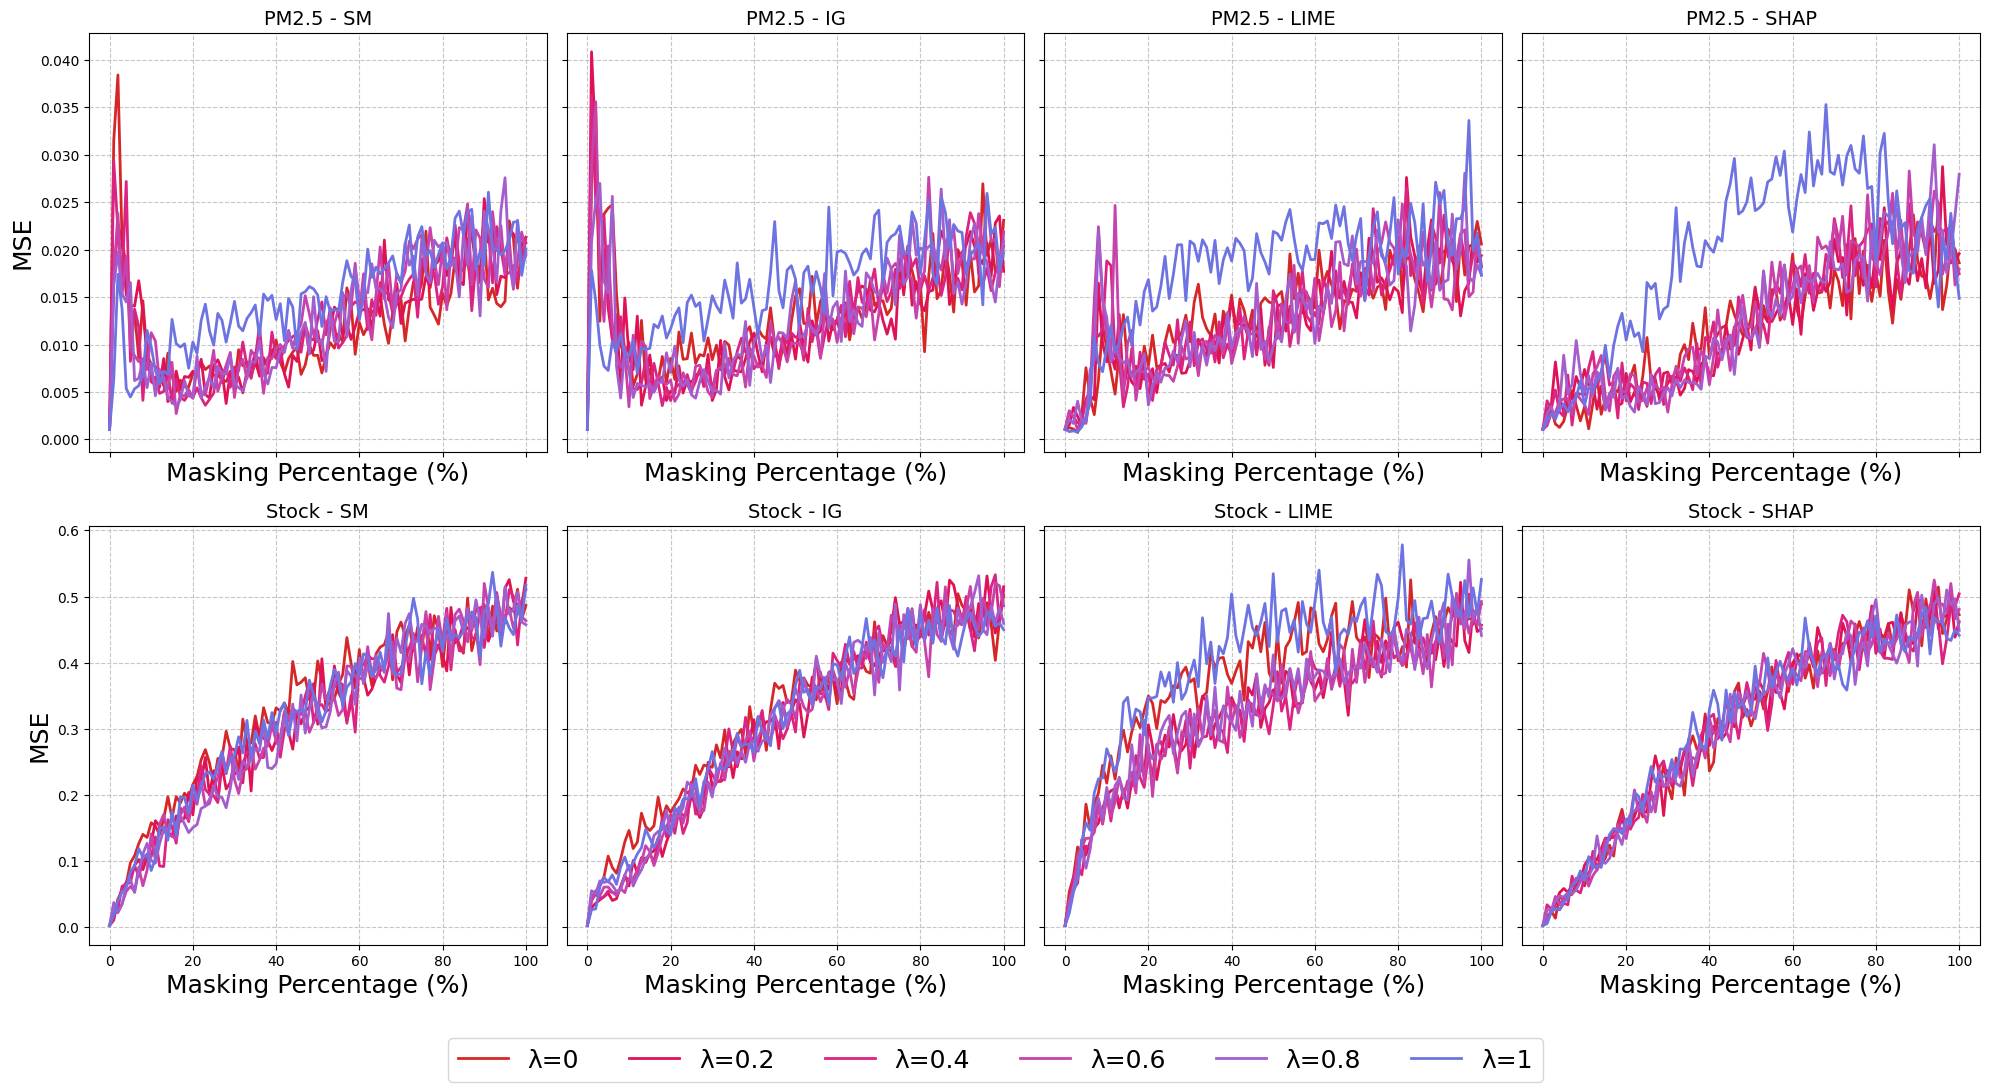

In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import dill
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from copy import deepcopy

# -----------------------
# 基本配置
# -----------------------
HOME = "/storage/d05/cys/CYS/robust-timepoint/"
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
N_SAMPLES = 25
DATASETS = ["PRSA", "SZtick"]                      # 行
DISPLAY_NAMES = {"PRSA": "PM2.5", "SZtick": "Stock"}
METHODS = ["SM", "IG", "LIME", "KS"]              # 列
DISPLAY_METHODS = {"LIME": "LIME", "KS": "SHAP", "SM": "SM", "IG": "IG"}

# 要对比的 lambda（已加入 0.8）
LAMBDAS = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# lambda -> Smooth_Adversial_Saliency 文件后缀
lambda2suffix = {0.2: "0p2", 0.4: "0p4", 0.6: "0p6", 0.8: "0p8"}

# λ 颜色
LAMBDA_COLORS = {
    0.0: "#d62728", 0.2: "#e01256", 0.4: "#db2482",
    0.6: "#c742ab", 0.8: "#a35dcc", 1.0: "#6e73e2",
}
LINESTYLE = "-"

MASKED_PCTS = list(range(0, 101, 1))

def evaluate_masked_performance(X, y, saliency, model, masked_percentages):
    mse_scores = []
    n_samples, n_timesteps, n_features = X.shape
    X_flat = X.reshape(n_samples, -1)
    saliency_flat = saliency.reshape(n_samples, -1)
    for pct in masked_percentages:
        X_masked = X_flat.copy()
        for i in range(n_samples):
            sorted_idx = np.argsort(saliency_flat[i])[::-1]
            n_total = n_timesteps * n_features
            n_mask = int(n_total * pct / 100)
            mask_indices = sorted_idx[:n_mask]
            noise = np.random.normal(0, 1, size=n_mask)
            X_masked[i, mask_indices] = noise
        X_masked = X_masked.reshape(n_samples, n_timesteps, n_features)
        X_tensor = torch.tensor(X_masked).to(DEVICE)
        y_tensor = torch.tensor(y).to(DEVICE)
        with torch.no_grad():
            preds = model(X_tensor)
            mse = nn.MSELoss()(preds.squeeze(), y_tensor).item()
        mse_scores.append(mse)
    return mse_scores

def load_saliency(data_name, method, lam):
    if lam == 0.0:
        p = os.path.join(HOME, "Results", "Saliency_Values", data_name, "Transformer", f"{method}.npy")
    elif lam == 1.0:
        p = os.path.join(HOME, "Results", "Smooth_Saliency", data_name, "Transformer", f"{method}.npy")
    else:
        suf = lambda2suffix.get(lam, None)
        if suf is None:
            raise FileNotFoundError(f"No suffix mapping for lambda={lam}.")
        p = os.path.join(HOME, "Results", "Smooth_Adversial_Saliency", data_name, "Transformer",
                         f"{method}_PSO_DTW_{suf}.npy")
    if not os.path.exists(p):
        raise FileNotFoundError(p)
    return np.load(p)[:N_SAMPLES]

def load_dataset_and_model(data_name):
    with open(os.path.join(HOME, "Datasets", f"{data_name}120.dill"), "rb") as f:
        dataset = dill.load(f)
    X_test = dataset[2][:N_SAMPLES]
    y_test = dataset[3][:N_SAMPLES]
    model_path = os.path.join(HOME, "Models", f"Transformer/{data_name}_120_BEST.pkl")
    model = torch.load(model_path, map_location=DEVICE)
    model.eval()
    return X_test, y_test, model

# -----------------------
# 作图（2×4，行共享 y 轴 & 行共享一个纵轴标签）
# -----------------------
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey='row')

# 全局图例（仅 λ）
legend_elems = [
    mlines.Line2D([], [], color=LAMBDA_COLORS[lam], linestyle=LINESTYLE, linewidth=2, label=f"λ={lam:g}")
    for lam in LAMBDA_COLORS.keys()
]

for r, data_name in enumerate(DATASETS):
    X_test, Y_test, model = load_dataset_and_model(data_name)
    for c, method in enumerate(METHODS):
        ax = axes[r, c]
        for lam in LAMBDAS:
            try:
                sal = load_saliency(data_name, method, lam)
            except FileNotFoundError as e:
                print(f"[WARN] missing saliency for {data_name}-{method}-λ{lam}: {e}")
                continue
            scores = evaluate_masked_performance(X_test, Y_test, sal, model, MASKED_PCTS)
            ax.plot(MASKED_PCTS, scores, color=LAMBDA_COLORS[lam], linestyle=LINESTYLE, linewidth=2)
            
        ax.set_title(f"{DISPLAY_NAMES.get(data_name, data_name)} - {DISPLAY_METHODS[method]}", fontsize=14)
        ax.set_xlabel("Masking Percentage (%)", fontsize=18)
        # ax.grid(True, linestyle="--", alpha=0.6)
        # 去掉各子图的单独 y 标签
        ax.set_ylabel("")
        if c == 0:
            ax.set_ylabel("MSE", fontsize=18)
        ax.grid(True, linestyle='--', alpha=0.7)
    # ax.set_ylim(0, 1.80)  # 统一纵轴范围
# # —— 给每一行添加一个“共享纵轴标签” ——
# for r in range(len(DATASETS)):
#     row_axes = axes[r, :]
#     y0 = min(ax.get_position().y0 for ax in row_axes)
#     y1 = max(ax.get_position().y1 for ax in row_axes)
#     ymid = (y0 + y1) / 2.0
#     # 0.015 可按需要微调到更靠左或靠右
#     fig.text(0.015, ymid, "MSE", rotation=90, va='center', ha='center', fontsize=18)

# 布局与图例
fig.legend(handles=legend_elems, loc="lower center", ncol=len(legend_elems),
           bbox_to_anchor=(0.5, -0.1), fontsize=18)
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)  # 为图例留出空间
# 保存
out_dir = os.path.join(HOME, "Results", "Plots")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "fidelity_lambda_grid_transformer.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"[SAVE] {out_path}")
plt.show()


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import dill
import pandas as pd
from copy import deepcopy

# -----------------------
# 1. 基本配置
# -----------------------
HOME = "/storage/d05/cys/CYS/robust-timepoint/"
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
N_SAMPLES = 25

# 数据集配置
DATASET_NAME = "SZtick"
METHODS = ["SM", "IG", "LIME", "KS"]
LAMBDAS = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
lambda2suffix = {0.2: "0p2", 0.4: "0p4", 0.6: "0p6", 0.8: "0p8"}
MASKED_PCTS = list(range(0, 101, 1))

# -----------------------
# 2. 辅助函数定义
# -----------------------
def evaluate_masked_performance(X, y, saliency, model, masked_percentages):
    """计算遮蔽后的 MSE"""
    mse_scores = []
    n_samples, n_timesteps, n_features = X.shape
    X_flat = X.reshape(n_samples, -1)
    saliency_flat = saliency.reshape(n_samples, -1)
    
    # 预先生成随机噪声以保证一致性 (可选)
    # 这里保持原逻辑，实时生成
    
    for pct in masked_percentages:
        X_masked = X_flat.copy()
        for i in range(n_samples):
            sorted_idx = np.argsort(saliency_flat[i])[::-1]
            n_total = n_timesteps * n_features
            n_mask = int(n_total * pct / 100)
            if n_mask > 0:
                mask_indices = sorted_idx[:n_mask]
                noise = np.random.normal(0, 1, size=n_mask)
                X_masked[i, mask_indices] = noise
        
        X_masked = X_masked.reshape(n_samples, n_timesteps, n_features)
        X_tensor = torch.tensor(X_masked, dtype=torch.float32).to(DEVICE)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(DEVICE)
        
        with torch.no_grad():
            preds = model(X_tensor)
            mse = nn.MSELoss()(preds.squeeze(), y_tensor).item()
        mse_scores.append(mse)
    return mse_scores

def load_saliency(data_name, method, lam):
    """加载解释性文件"""
    if lam == 0.0:
        p = os.path.join(HOME, "Results", "Saliency_Values", data_name, "Transformer", f"{method}.npy")
    elif lam == 1.0:
        p = os.path.join(HOME, "Results", "Smooth_Saliency", data_name, "Transformer", f"{method}.npy")
    else:
        suf = lambda2suffix.get(lam, None)
        p = os.path.join(HOME, "Results", "Smooth_Adversial_Saliency", data_name, "Transformer",
                         f"{method}_PSO_DTW_{suf}.npy")
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing: {p}")
    return np.load(p)[:N_SAMPLES]

def load_dataset_and_model(data_name):
    """加载数据集和模型"""
    with open(os.path.join(HOME, "Datasets", f"{data_name}120.dill"), "rb") as f:
        dataset = dill.load(f)
    X_test = dataset[2][:N_SAMPLES]
    y_test = dataset[3][:N_SAMPLES]
    model_path = os.path.join(HOME, "Models", f"Transformer/{data_name}_120_BEST.pkl")
    model = torch.load(model_path, map_location=DEVICE)
    model.eval()
    return X_test, y_test, model

def smooth_curve(data, window=10):
    """对曲线进行平滑处理"""
    return pd.Series(data).rolling(window=window, min_periods=1, center=True).mean().values

# -----------------------
# 3. 执行计算并缓存结果
# -----------------------
print(f"Loading Dataset: {DATASET_NAME}...")
X_test, Y_test, model = load_dataset_and_model(DATASET_NAME)

# 结构: results_cache[method][lambda] = smooth_scores
results_cache = {}

print("Starting evaluation...")
for method in METHODS:
    results_cache[method] = {}
    print(f"Processing Method: {method}")
    for lam in LAMBDAS:
        try:
            # 1. 加载解释
            sal = load_saliency(DATASET_NAME, method, lam)
            # 2. 计算原始 MSE
            raw_scores = evaluate_masked_performance(X_test, Y_test, sal, model, MASKED_PCTS)
            # 3. 计算平滑 MSE
            smooth_scores = smooth_curve(raw_scores, window=10)
            
            results_cache[method][lam] = smooth_scores
        except FileNotFoundError:
            print(f"  [WARN] Skipping {method} λ={lam} (File not found)")
            results_cache[method][lam] = None
        except Exception as e:
            print(f"  [ERR] Error processing {method} λ={lam}: {e}")
            results_cache[method][lam] = None

print("\nAll calculations done! Data stored in 'results_cache'.")


Loading Dataset: SZtick...
Starting evaluation...
Processing Method: SM
Processing Method: IG
Processing Method: LIME
Processing Method: KS

All calculations done! Data stored in 'results_cache'.


/tmp/ipykernel_4155733/868025463.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r')


[SAVE] Plot saved to: /storage/d05/cys/CYS/robust-timepoint/Results/Plots/fidelity_lambda_optimized_2x2.png


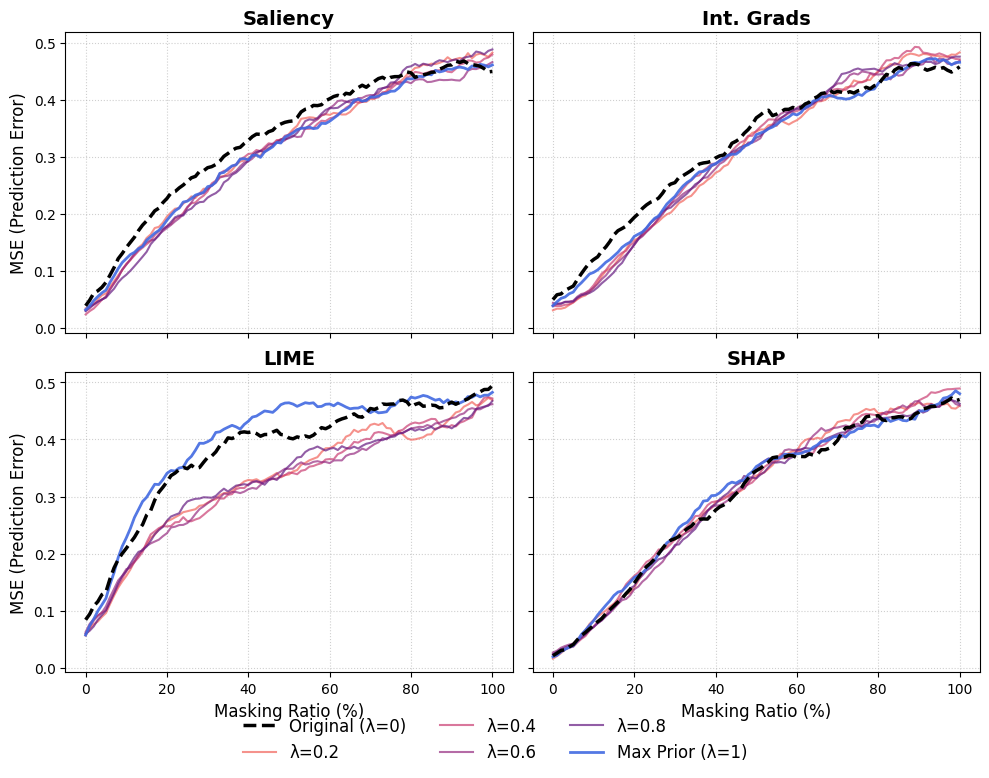

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# -----------------------
# 1. 绘图配置
# -----------------------
DISPLAY_METHODS = {"LIME": "LIME", "KS": "SHAP", "SM": "Saliency", "IG": "Int. Grads"}
# 如果 Cell 1 已经定义过 LAMBDAS，这里可以不写，但为了独立性保留
LAMBDAS = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

def get_style(lam):
    """定义不同 lambda 的线条样式"""
    if lam == 0.0:
        return {"color": "black", "linestyle": "--", "linewidth": 2.5, "alpha": 1.0, "zorder": 10, "label": "Original (λ=0)"}
    elif lam == 1.0:
        return {"color": "#4169E1", "linestyle": "-", "linewidth": 2.0, "alpha": 0.9, "zorder": 9, "label": "Max Prior (λ=1)"}
    else:
        # 使用 magma_r 颜色映射生成渐变色
        cmap = plt.cm.get_cmap('magma_r') 
        color = cmap(0.2 + 0.5 * (lam / 0.8)) 
        return {"color": color, "linestyle": "-", "linewidth": 1.5, "alpha": 0.7, "zorder": 5, "label": f"λ={lam}"}

# -----------------------
# 2. 执行绘图 (2x2 布局)
# -----------------------
# 设置 figsize 为 (10, 8) 保证接近正方形的子图比例
fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

# 遍历方法填充子图
for i, method in enumerate(METHODS):
    r, c = divmod(i, 2)
    ax = axes[r, c]
    
    # 从缓存中获取数据绘图
    if method in results_cache:
        for lam in LAMBDAS:
            scores = results_cache[method].get(lam)
            if scores is not None:
                style = get_style(lam)
                # 绘制
                ax.plot(MASKED_PCTS, scores, **{k:v for k,v in style.items() if k != 'label'})
    
    # 样式修饰
    ax.set_title(f"{DISPLAY_METHODS[method]}", fontsize=14, fontweight='bold')
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # 坐标轴标签控制：仅左侧显示 Y 轴，仅底部显示 X 轴
    if c == 0:
        ax.set_ylabel("MSE (Prediction Error)", fontsize=12)
    if r == 1:
        ax.set_xlabel("Masking Ratio (%)", fontsize=12)

# -----------------------
# 3. 图例与保存
# -----------------------
handles = []
for lam in LAMBDAS:
    s = get_style(lam)
    line = mlines.Line2D([], [], color=s['color'], linestyle=s['linestyle'], 
                         linewidth=s['linewidth'], alpha=s['alpha'], label=s['label'])
    handles.append(line)

# 底部居中图例
fig.legend(handles=handles, loc="lower center", ncol=3, 
           bbox_to_anchor=(0.5, 0.02), fontsize=12, frameon=False)

plt.tight_layout()
# 调整边距：底部留给图例，顶部留一点空隙
plt.subplots_adjust(bottom=0.15, top=0.95)

# 保存路径
out_dir = os.path.join(HOME, "Results", "Plots")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "fidelity_lambda_optimized_2x2.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")

print(f"[SAVE] Plot saved to: {out_path}")
plt.show()
